# Teste de viabilidade

**Caio Geraldes, 2021**

Este notebook testa a viabilidade dos algoritmos do m√≥dulo `lexicogenero`, de minha autoria, para selecionar, dividir e organizar dados de textos em prosa em grego antigo para a disciplina FLL5133-2021.
O c√≥digo fonte dos scripts utilizados aqui, bem como dos testes de qualidade est√£o dispon√≠veis em meu [GitHub](https://github.com/caiogeraldes/lexico-e-genero/).

## Carregamento e organiza√ß√£o dos dados importados do Diorisis

Pretendo utilizar o corpus anotado [Diorisis](https://figshare.com/articles/dataset/The_Diorisis_Ancient_Greek_Corpus_JSON_/12251468) de Alessandro Vatri e Barbara McGillyvray, dispon√≠vel em formato `.json` e com lemmatiza√ß√£o confi√°vel ([Vatri, 2020](https://brill.com/view/journals/jgl/20/2/article-p179_4.xml)).
 Para processar esse corpus, utilizei as fun√ß√µes criadas em [../src/lexicogenero/ferramentas/diorisis_reader.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/ferramentas/diorisis_reader.py).
 A lista de *stop words* utilizada vem de [Rodda, 2020](https://github.com/MartinaAstridRodda/dphil-thesis), com algumas adi√ß√µes (c√≥digo em [../src/lexicogenero/grc.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/grc.py)).

In [88]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

In [89]:
from lexicogenero.ferramentas.diorisis_reader import carrega_textos, em_pandas, sent_pandas
from lexicogenero.main import DIORISIS_PATH
from lexicogenero.grc import STOPS_LIST

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

Neste teste, usaremos como corpus os textos de historiografia e prosa filos√≥fica (di√°logos e tratados) de autores do per√≠odo cl√°ssico:

- Historiografia:
    - Her√≥doto
    - Xenofonte:
        - Cirop√©dia
        - An√°base
        - Hel√™nica
    - Tuc√≠dides
- Prosa filos√≥fica:
    - Plat√£o
    - Xenofonte:
        - Agesilau
        - Hier√£o
        - Simp√≥sio
        - Apologia
        - Memorabilia

In [90]:
DATA = "data.csv"
SENTS = "sents.csv"
REAPROVEITAR = True

if not REAPROVEITAR or (DATA not in os.listdir() or SENTS not in os.listdir()):
    ignorados = [
        "Xenophon (0032) - On the Art of Horsemanship (013).json",
        "Xenophon (0032) - Economics (003).json",
        "Xenophon (0032) - Ways and Means (011).json",
        "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
        "Xenophon (0032) - On the Cavalry Commander (012).json",
        "Xenophon (0032) - On Hunting (014).json",
        "Xenophon (0032) - Apology (005).json",
        "Plato (0059) - Alcibiades 2 (014).json", # Anota√ß√£o problem√°tica
    ]

    corpus = carrega_textos(autores=['Herodotus', 
                                     'Thucydides', 
                                     'Plato', 
                                     'Xenophon (0032)', # Exclui Xenofonte de √âfeso 
                                     ],
                            diorisis_path=DIORISIS_PATH,
                            ignore=ignorados,
                            verbose=False)
    df_tokens = em_pandas(corpus)
    df_sents = sent_pandas(corpus)
    del corpus
    df_tokens.to_csv(DATA, index=False)
    df_sents.to_csv(SENTS, index=False)
        
else:
    print('Carregando dataframe previamente salvo')
    df_tokens = pd.read_csv(DATA)
    df_sents = pd.read_csv(SENTS)

Criando DF para: Herodotus (0016) - Histories (001).json
Criando DF para: Thucydides (0003) - History (001).json
Criando DF para: Plato (0059) - Cleitophon (029).json
Criando DF para: Plato (0059) - Menexenus (028).json
Criando DF para: Plato (0059) - Symposium (011).json
Criando DF para: Plato (0059) - Hipparchus (015).json
Criando DF para: Plato (0059) - Lovers (016).json
Criando DF para: Plato (0059) - Minos (033).json
Criando DF para: Plato (0059) - Phaedrus (012).json
Criando DF para: Plato (0059) - Epinomis (035).json
Criando DF para: Plato (0059) - Apology (002).json
Criando DF para: Plato (0059) - Protagoras (022).json
Criando DF para: Plato (0059) - Timaeus (031).json
Criando DF para: Plato (0059) - Hippias Minor (026).json
Criando DF para: Plato (0059) - Sophist (007).json
Criando DF para: Plato (0059) - Gorgias (023).json
Criando DF para: Plato (0059) - Laches (019).json
Criando DF para: Plato (0059) - Critias (032).json
Criando DF para: Plato (0059) - Euthyphro (001).json
C

**Formato do DF**: ainda n√£o decidi se seria mais eficiente utilizar um data frame organizado por token ou por senten√ßas. A implementa√ß√£o de ambos √© muito semelhante e pode ser vista em `../src/lexicogenero/ferramentas/diorisis_parser.py`

In [92]:
df_tokens.head()

sent_id location           form          lemma      POS  \
0       1    1.t.1       ·º©œÅŒøŒ¥·ΩπœÑŒøœÖ       ·º©œÅ·ΩπŒ¥ŒøœÑŒøœÇ   proper   
1       1    1.t.1  ·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉ·Ω≥ŒøœÇ  ·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉŒµ·ΩªœÇ   proper   
2       1    1.t.1       ·º±œÉœÑŒøœÅ·Ω∑Œ∑œÇ        ·º±œÉœÑŒøœÅ·Ω∑Œ±     noun   
3       1    1.t.1       ·ºÄœÄ·ΩπŒ¥ŒµŒæŒπœÇ       ·ºÄœÄ·ΩπŒ¥ŒµŒæŒπœÇ     noun   
4       1    1.t.1            ·º•Œ¥Œµ            ·ΩÖŒ¥Œµ  pronoun   

                   analyses id                                     file  \
0               masc gen sg  1  Herodotus (0016) - Histories (001).json   
1  masc gen sg (epic ionic)  2  Herodotus (0016) - Histories (001).json   
2   fem gen sg (epic ionic)  3  Herodotus (0016) - Histories (001).json   
3                fem nom sg  4  Herodotus (0016) - Histories (001).json   
4                fem nom sg  5  Herodotus (0016) - Histories (001).json   

      author       text  
0  Herodotus  Histories  
1  Herodotus  Histories  
2  Herodotus  Histories  
3  Herodotus  Histories  
4  Herodotus  Histories

In [93]:
df_sents.head()

sent_id location                                              forms  \
0       1    1.t.1  ·º©œÅŒøŒ¥·ΩπœÑŒøœÖ ·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉ·Ω≥ŒøœÇ ·º±œÉœÑŒøœÅ·Ω∑Œ∑œÇ ·ºÄœÄ·ΩπŒ¥ŒµŒæŒπœÇ ·º•Œ¥Œµ ,...   
1       2    1.1.1  Œ†ŒµœÅœÉ·Ω≥œâŒΩ Œº·Ω≥ŒΩ ŒΩœÖŒΩ Œø·º± Œª·ΩπŒ≥ŒπŒøŒπ Œ¶Œø·Ω∑ŒΩŒπŒ∫Œ±œÇ Œ±·º∞œÑ·Ω∑ŒøœÖœÇ œÜŒ±œÉ...   
2       3    1.1.2  œÑŒø·ΩªœÑŒøœÖœÇ Œ≥·Ω∞œÅ ·ºÄœÄ·Ω∏ œÑ·øÜœÇ ·ºòœÅœÖŒ∏œÅ·øÜœÇ Œ∫Œ±ŒªŒµŒøŒº·Ω≥ŒΩŒ∑œÇ Œ∏Œ±Œª·Ω±œÉœÉŒ∑...   
3       4    1.1.7  œÑ·Ω∏ Œ¥·Ω≤ ·ºåœÅŒ≥ŒøœÇ œÑŒø·ø¶œÑŒøŒΩ œÑ·Ω∏ŒΩ œáœÅ·ΩπŒΩŒøŒΩ œÄœÅŒøŒµ·øñœáŒµ ·ºÖœÄŒ±œÉŒπ œÑ·ø∂...   
4       5    1.1.9  ·ºÄœÄŒπŒ∫ŒøŒº·Ω≥ŒΩŒøœÖœÇ Œ¥·Ω≤ œÑŒø·ΩªœÇ Œ¶Œø·Ω∑ŒΩŒπŒ∫Œ±œÇ ·ºêœÇ Œ¥·Ω¥ œÑ·Ω∏ ·ºåœÅŒ≥ŒøœÇ œÑŒø...   

                                             lemmata  \
0  ·º©œÅ·ΩπŒ¥ŒøœÑŒøœÇ ·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉŒµ·ΩªœÇ ·º±œÉœÑŒøœÅ·Ω∑Œ± ·ºÄœÄ·ΩπŒ¥ŒµŒæŒπœÇ ·ΩÖŒ¥Œµ ·Ω°œÇ...   
1  Œ†·Ω≥œÅœÉŒµœÖœÇ Œº·Ω≥ŒΩ ŒΩ·ø¶ŒΩ ·ΩÅ Œª·ΩπŒ≥ŒπŒøœÇ Œ¶Œø·øñŒΩŒπŒæ Œ±·º¥œÑŒπŒøœÇ œÜŒ∑Œº·Ω∑ Œ≥·Ω∑...   
2  Œø·ΩóœÑŒøœÇ Œ≥·Ω±œÅ ·ºÄœÄ·Ωπ ·ΩÅ ·ºòœÅœÖŒ∏œÅŒ±·Ω∑ Œ∫Œ±Œª·Ω≥œâ Œ∏·Ω±ŒªŒ±œÉœÉŒ± ·ºÄœÜŒπŒ∫ŒΩ·Ω≥ŒøŒº...   
3  ·ΩÅ Œ¥·Ω≥ ·ºåœÅŒ≥ŒøœÇ Œø·ΩóœÑŒøœÇ ·ΩÅ œáœÅ·ΩπŒΩŒøœÇ œÄœÅŒø·Ω≥œáœâ ·ºÖœÄŒ±œÇ ·ΩÅ ·ºêŒΩ ·ΩÅ ŒΩ...   
4  ·ºÄœÜŒπŒ∫ŒΩ·Ω≥ŒøŒºŒ±Œπ Œ¥·Ω≥ ·ΩÅ Œ¶Œø·øñŒΩŒπŒæ Œµ·º∞œÇ Œ¥·Ωµ ·ΩÅ ·ºåœÅŒ≥ŒøœÇ Œø·ΩóœÑŒøœÇ Œ¥Œπ...   

                                      file     author       text  
0  Herodotus (0016) - Histories (001).json  Herodotus  Histories  
1  Herodotus (0016) - Histories (001).json  Herodotus  Histories  
2  Herodotus (0016) - Histories (001).json  Herodotus  Histories  
3  Herodotus (0016) - Histories (001).json  Herodotus  Histories  
4  Herodotus (0016) - Histories (001).json  Herodotus  Histories

## Anotando G√™nero

In [94]:
hist = [
    "Herodotus (0016) - Histories (001).json",
    "Thucydides (0003) - History (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
]

In [95]:
# Deve haver uma maneira menos rocambolesca para resolver isso
df_tokens['genero'] = np.nan
df_tokens.loc[df_tokens.file.isin(hist), 'genero'] = "hist"
df_tokens.genero.fillna("filo", inplace=True)
df_sents['genero'] = np.nan
df_sents.loc[df_sents.file.isin(hist), 'genero'] = "hist"
df_sents.genero.fillna("filo", inplace=True)

Para meu modelo funcionar, ser√° necess√°rio ter uma quantidade relativamente equilibrada de dados entre autores de prosa historiogr√°fica e prosa filos√≥fica, a sele√ß√£o parece razo√°vel.
Qualquer tentativa de aumentar os dados de historiografia for√ßaria aumentar o escopo temporal (o pr√≥ximo autor seria Pol√≠bio, j√° do per√≠odo helen√≠stico).
Nota-se que a diferen√ßa aumenta quando tratamos de senten√ßas e n√£o de tokens, indicando que as senten√ßas em textos historiogr√°ficos devem ser um pouco mais longas na m√©dia.

<AxesSubplot:>

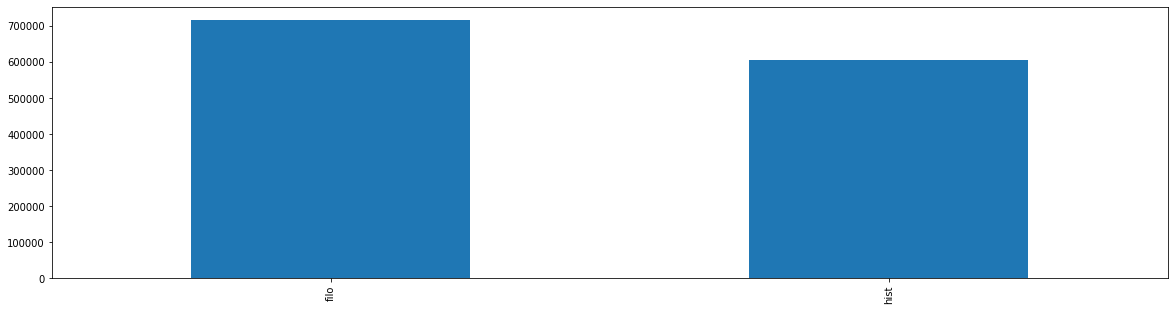

In [96]:
df_tokens.genero.value_counts().plot(kind='bar')

<AxesSubplot:>

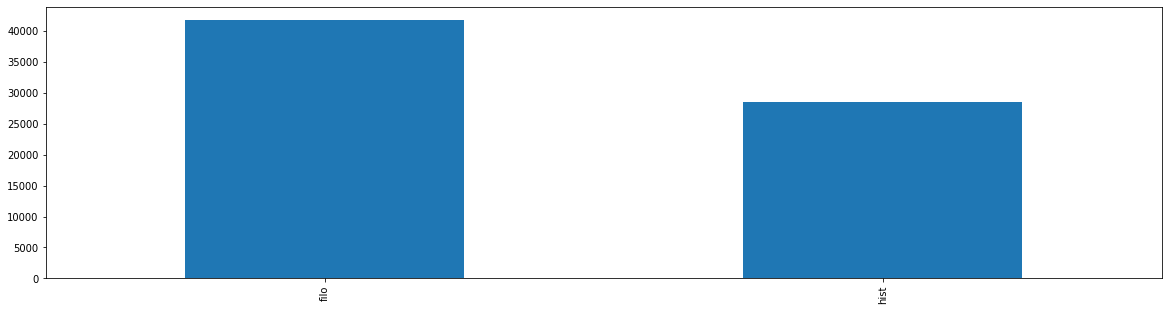

In [97]:
df_sents.genero.value_counts().plot(kind='bar')

## Verbos por g√™nero (dataframe de tokens)

In [98]:
df_verbos = df_tokens.loc[(df_tokens.POS == "verb") & (-df_tokens.lemma.isin(STOPS_LIST)),]
df_verbos.head()

sent_id location         form       lemma   POS  \
30       1    1.t.1  ·ºÄœÄŒøŒ¥ŒµœáŒ∏·Ω≥ŒΩœÑŒ±  ·ºÄœÄŒøŒ¥·Ω≥œáŒøŒºŒ±Œπ  verb   
42       1    1.t.1   ·ºêœÄŒøŒª·Ω≥ŒºŒ∑œÉŒ±ŒΩ     œÄŒøŒªŒµŒº·Ω≥œâ  verb   
62       3    1.1.2   Œ∫Œ±ŒªŒµŒøŒº·Ω≥ŒΩŒ∑œÇ       Œ∫Œ±Œª·Ω≥œâ  verb   
64       3    1.1.2  ·ºÄœÄŒπŒ∫ŒøŒº·Ω≥ŒΩŒøœÖœÇ  ·ºÄœÜŒπŒ∫ŒΩ·Ω≥ŒøŒºŒ±Œπ  verb   
71       3    1.1.2   Œø·º∞Œ∫·ΩµœÉŒ±ŒΩœÑŒ±œÇ       Œø·º∞Œ∫·Ω≥œâ  verb   

                                             analyses  id  \
30  aor part pass neut nom/voc/acc pl;aor part pas...  28   
42                                 aor ind act 3rd pl  38   
62  fut part mid fem gen sg (attic epic ionic);pre...   6   
64                   aor part mid masc acc pl (ionic)   8   
71                           aor part act masc acc pl  14   

                                       file     author       text genero  
30  Herodotus (0016) - Histories (001).json  Herodotus  Histories   hist  
42  Herodotus (0016) - Histories (001).json  Herodotus  Histories   hist  
62  Herodotus (0016) - Histories (001).json  Herodotus  Histories   hist  
64  Herodotus (0016) - Histories (001).json  Herodotus  Histories   hist  
71  Herodotus (0016) - Histories (001).json  Herodotus  Histories   hist

A filtragem n√£o causa mudan√ßa na propor√ß√£o entre documentos de historiografia e filosofia.

<AxesSubplot:>

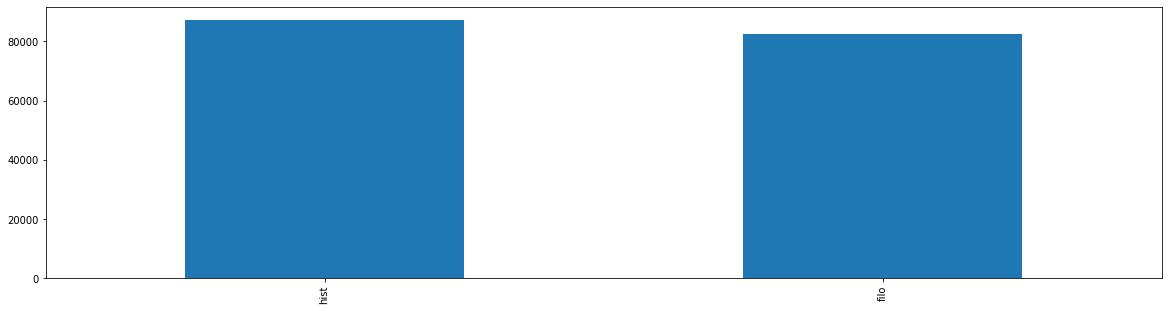

In [99]:
df_verbos.genero.value_counts().plot(kind='bar')

In [100]:
filo_verbos = df_verbos[df_verbos.genero == "filo"].lemma
filo_verbos.value_counts()

Œø·º¥ŒøŒºŒ±Œπ          1728
Œø·º∂Œ¥Œ±            1451
œÜŒ±·Ω∑ŒΩœâ           1198
Œ≤Œø·ΩªŒªŒøŒºŒ±Œπ        1163
Œ¥Œµ·øñ             1017
                ... 
·ºÄŒΩŒ±Œ∫·Ω±ŒºœÄœÑœâ          1
ŒºŒ±ŒªŒ±Œ∫·Ω∑Œ∂ŒøŒºŒ±Œπ        1
·ºêŒΩŒ±ŒΩœÑŒπŒøŒªŒøŒ≥·Ω≥œâ       1
œÄŒ±œÅœâŒΩœÖŒº·Ω≥œâ          1
·ºêœÜ·Ω≥Œ∂ŒøŒºŒ±Œπ           1
Name: lemma, Length: 3652, dtype: int64

<AxesSubplot:ylabel='Density'>

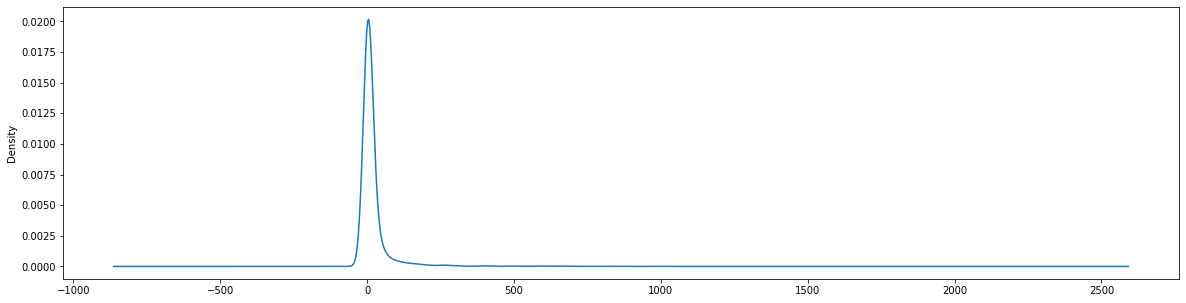

In [101]:
filo_verbos.value_counts().plot(kind='density')

In [102]:
hist_verbos = df_verbos[df_verbos.genero == "hist"].lemma
hist_verbos.value_counts()

Œ≤Œø·ΩªŒªŒøŒºŒ±Œπ        1177
ŒªŒ±ŒºŒ≤·Ω±ŒΩœâ          994
·ºÄœÜŒπŒ∫ŒΩ·Ω≥ŒøŒºŒ±Œπ       915
·ºîœÅœáŒøŒºŒ±Œπ          872
œÄ·Ω±œÅŒµŒπŒºŒπ          822
                ... 
·ºêœÄŒµŒπŒ∫·Ω±Œ∂œâ           1
·ºÄœÄŒøŒ∫Œ∑Œ¥Œµ·Ωªœâ          1
œÄœÖŒ∫ŒΩ·Ωπœâ             1
Œ∫Œ±Œ∏ŒπœÄœÄ·Ω±Œ∂ŒøŒºŒ±Œπ       1
·ºêŒæŒ±œÖŒª·Ω∑Œ∂ŒøŒºŒ±Œπ        1
Name: lemma, Length: 4331, dtype: int64

<AxesSubplot:ylabel='Density'>

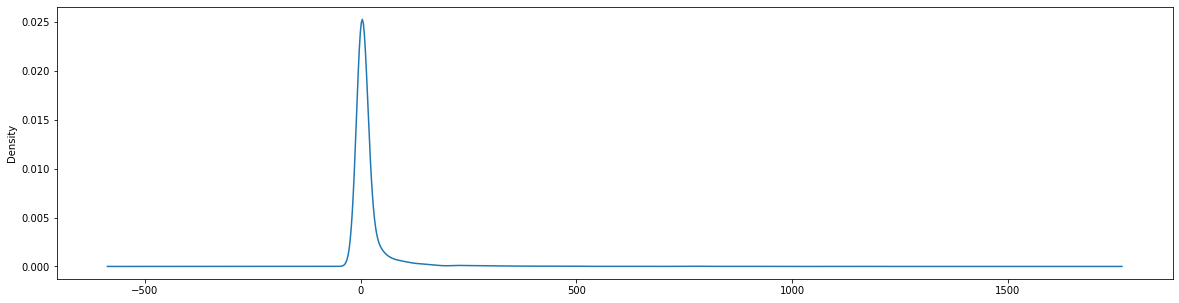

In [103]:
hist_verbos.value_counts().plot(kind='density')

## Naive Bayes


### Apenas de tokens

O resultado √© terr√≠vel, provavelmente porque a implementa√ß√£o do modelo n√£o √© a melhor, afinal o `DOCUMENTO` e suas componentes s√£o a mesma entidade.

In [104]:
x, y = df_verbos.lemma, df_verbos.genero

In [105]:

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

In [106]:
vocab_filo = Counter(filo)
vocab_hist = Counter(hist)

In [107]:
n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

In [108]:
n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [109]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [110]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

In [111]:
teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")
        
perf_counter = Counter(performance_labels)

In [112]:
perf_counter

Counter({'VN': 17311, 'FP': 16684})

### Com senten√ßas

O modelo assim performa melhor, mas √© pouco espec√≠fico para os meus interesses: que o vocabul√°rio da prosa filos√≥fica e historiogr√°fica s√£o distintos diz pouco sobre sua sele√ß√£o de verbos.

In [113]:
def achatar(lista):
    return list(itertools.chain(*lista))

df_sents['lst_lemmata'] = df_sents.lemmata.str.split()
df_sents.dropna(inplace=True)

In [114]:
x, y = df_sents.lst_lemmata, df_sents.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

In [115]:
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [116]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [117]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

In [118]:
performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

In [119]:
perf_counter = Counter(performance_labels)

perf_counter

Counter({'VN': 2716, 'VP': 8261, 'FN': 2943, 'FP': 157})

In [120]:
precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precis√£o:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acur√°cia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precis√£o:  0.9813494891898313
Cobertura: 0.7373259550160657
Acur√°cia:  0.779782624138666
Medida F:  0.8420140658444601


# Conclus√µes

- O banco de dados anotado Diorisis oferece as anota√ß√µes necess√°rias e √© relativamente f√°cil de processar.
- O corpus proposto oferece um n√∫mero relativamente equilibrado de dados para as categorias a serem classificadas e o algoritmo de processamento permite que ele seja expandido conforme necess√°rio.
- Ser√° importante revisar a suaviza√ß√£o utilizada (no caso Laplace) para poder obter um modelo funcional se for utilizado um modelo como o Naive Bayes apenas com os verbos, embora a princ√≠pio j√° seja poss√≠vel afirmar que esse modelo n√£o funcionar√° bem assim.
- Se for poss√≠vel codificar a informa√ß√£o de `df_sents.lst_lemmata` selecionar os verbos principais (utilizando o dependency parser do `stanza-perseus`), os resultados poder√£o ser mais consistentes com aqueles que s√£o de meu interesse.

# Outra abordagem

Testando os exemplos por meio de agrupamento em par√°grafos:

In [121]:
df_tokens[['div_sup', 'par']] = df_tokens.location.str.split('.', n=1, expand=True)

In [122]:
df_tokens.dropna(inplace=True)

In [123]:
j = df_tokens.groupby(['author', 'text', 'file','div_sup', 'par', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

In [124]:
df_tokens_par = j.reset_index()

In [125]:
df_tokens_par

author       text                                     file div_sup  \
0      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
1      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
2      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
3      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
4      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
...          ...        ...                                      ...     ...   
56301   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56302   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56303   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56304   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56305   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   

        par genero                                              lemma  
0       1.1   hist  Œ†·Ω≥œÅœÉŒµœÖœÇ Œº·Ω≥ŒΩ ŒΩ·ø¶ŒΩ ·ΩÅ Œª·ΩπŒ≥ŒπŒøœÇ Œ¶Œø·øñŒΩŒπŒæ Œ±·º¥œÑŒπŒøœÇ œÜŒ∑Œº·Ω∑ Œ≥·Ω∑...  
1      1.13   hist  ·ΩÅ Œ¥·Ω≥ ·ΩÅ ·ΩÑŒΩŒøŒºŒ± Œµ·º∞Œº·Ω∑ , Œ∫Œ±œÑ·Ω± Œ±·ΩêœÑ·ΩπœÇ ·ΩÅ Œ∫Œ±·Ω∑ ·ºùŒªŒªŒ∑ŒΩ Œª·Ω≥Œ≥...  
2      1.14   hist  Œø·ΩóœÑŒøœÇ ·ºµœÉœÑŒ∑ŒºŒπ Œ∫Œ±œÑ·Ω± œÄœÅ·ΩªŒºŒΩŒ± ·ΩÅ ŒΩŒ±·ø¶œÇ ·Ω†ŒΩ·Ω≥ŒøŒºŒ±Œπ ·ΩÅ œÜŒøœÅœÑ...  
3      1.17   hist  ·ΩÅ Œº·Ω≥ŒΩ Œ¥·Ωµ œÄŒªŒµ·Ω∑œâŒΩ ·ΩÅ Œ≥œÖŒΩ·Ωµ ·ºÄœÄŒøœÜŒµ·ΩªŒ≥œâ , ·ΩÅ Œ¥·Ω≥ ·º∏·ΩΩ œÉ·ΩªŒΩ ...  
4      1.19   hist  Œµ·º∞œÉŒ≤·Ω±ŒªŒªœâ Œ¥·Ω≥ Œµ·º∞œÇ ·ΩÅ ŒΩŒ±·ø¶œÇ Œø·º¥œáŒøŒºŒ±Œπ ·ºÄœÄŒøœÄŒª·Ω≥œâ ·ºêœÄ·Ω∑ Œë·º¥Œ≥...  
...     ...    ...                                                ...  
56301   6.1   filo  ·ºÑŒΩ ; Œ∫Œ±·Ω∑ Œ≥·Ω±œÅ ·ºÄŒ∫Œø·Ωªœâ ·ΩÅ ŒîŒπ·ΩπŒΩœÖœÉŒøœÇ Œº·Ω≥ŒΩ ·ºêœÄŒµœÅœâœÑ·Ω±œâ Œ±·ΩêœÑ...  
56302   6.5   filo  ·ºîŒøŒπŒ∫Œ± Œ≥·Ω±œÅ Œø·Ωê Œ¥ŒπŒ¥·Ω±œÉŒ∫œâ ·ΩÅ œÉœá·øÜŒºŒ± ·ºÄŒªŒª·Ω± ·ºêœÜ·Ω≥Œ∂ŒøŒºŒ±Œπ œÄœÅ·Ω±...  
56303   7.1   filo  œÑ·Ω≥ŒªŒøœÇ Œ¥·Ω≥ ·ΩÅ œÉœÖŒºœÄ·ΩπœÑŒ∑œÇ Œµ·º∂Œ¥ŒøŒΩ œÄŒµœÅŒπŒ≤·Ω±ŒªŒªœâ œÑŒµ ·ºÄŒªŒª·ΩµŒªœâŒΩ...  
56304   7.4   filo  Œ£œâŒ∫œÅ·Ω±œÑŒ∑œÇ Œ¥·Ω≥ Œ∫Œ±·Ω∑ ·ΩÅ ·ºÑŒªŒªŒøœÇ ·ΩÅ ·ΩëœÄŒøŒº·Ω≥ŒΩœâ œÄœÅ·ΩπœÇ Œõ·ΩªŒ∫œâŒΩ Œ∫...  
56305   7.6   filo        Œø·ΩóœÑŒøœÇ ·ΩÅ œÑ·ΩπœÑŒµ œÉœÖŒºœÄ·ΩπœÉŒπŒøŒΩ Œ∫Œ±œÑ·Ω±ŒªœÖœÉŒπœÇ Œ≥·Ω∑Œ≥ŒΩŒøŒºŒ±Œπ .  

[56306 rows x 7 columns]

<AxesSubplot:>

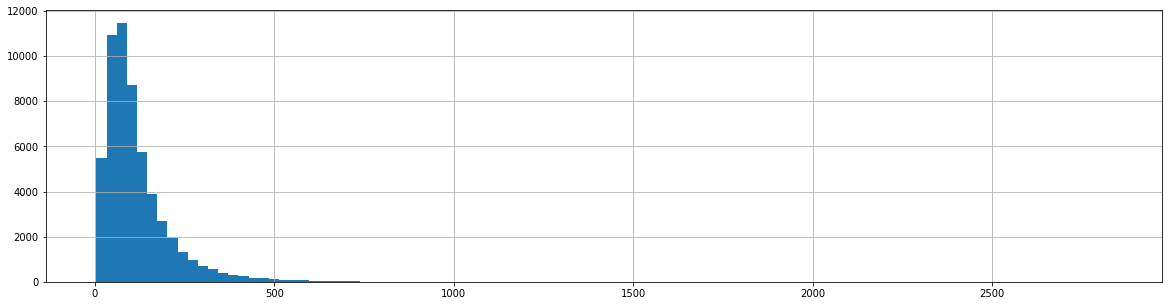

In [126]:
df_tokens_par.lemma.apply(len).hist(grid=True, bins=100)

In [127]:
minimo, maximo = df_tokens_par.lemma.apply(len).quantile([.05, .95]).values
tamanho_representativo = (df_tokens_par.lemma.apply(len) > minimo) & (df_tokens_par.lemma.apply(len) < maximo)

In [128]:
df_tokens_par.loc[tamanho_representativo]

author       text                                     file div_sup  \
0      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
1      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
2      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
3      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
4      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
...          ...        ...                                      ...     ...   
56301   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56302   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56303   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56304   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56305   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   

        par genero                                              lemma  
0       1.1   hist  Œ†·Ω≥œÅœÉŒµœÖœÇ Œº·Ω≥ŒΩ ŒΩ·ø¶ŒΩ ·ΩÅ Œª·ΩπŒ≥ŒπŒøœÇ Œ¶Œø·øñŒΩŒπŒæ Œ±·º¥œÑŒπŒøœÇ œÜŒ∑Œº·Ω∑ Œ≥·Ω∑...  
1      1.13   hist  ·ΩÅ Œ¥·Ω≥ ·ΩÅ ·ΩÑŒΩŒøŒºŒ± Œµ·º∞Œº·Ω∑ , Œ∫Œ±œÑ·Ω± Œ±·ΩêœÑ·ΩπœÇ ·ΩÅ Œ∫Œ±·Ω∑ ·ºùŒªŒªŒ∑ŒΩ Œª·Ω≥Œ≥...  
2      1.14   hist  Œø·ΩóœÑŒøœÇ ·ºµœÉœÑŒ∑ŒºŒπ Œ∫Œ±œÑ·Ω± œÄœÅ·ΩªŒºŒΩŒ± ·ΩÅ ŒΩŒ±·ø¶œÇ ·Ω†ŒΩ·Ω≥ŒøŒºŒ±Œπ ·ΩÅ œÜŒøœÅœÑ...  
3      1.17   hist  ·ΩÅ Œº·Ω≥ŒΩ Œ¥·Ωµ œÄŒªŒµ·Ω∑œâŒΩ ·ΩÅ Œ≥œÖŒΩ·Ωµ ·ºÄœÄŒøœÜŒµ·ΩªŒ≥œâ , ·ΩÅ Œ¥·Ω≥ ·º∏·ΩΩ œÉ·ΩªŒΩ ...  
4      1.19   hist  Œµ·º∞œÉŒ≤·Ω±ŒªŒªœâ Œ¥·Ω≥ Œµ·º∞œÇ ·ΩÅ ŒΩŒ±·ø¶œÇ Œø·º¥œáŒøŒºŒ±Œπ ·ºÄœÄŒøœÄŒª·Ω≥œâ ·ºêœÄ·Ω∑ Œë·º¥Œ≥...  
...     ...    ...                                                ...  
56301   6.1   filo  ·ºÑŒΩ ; Œ∫Œ±·Ω∑ Œ≥·Ω±œÅ ·ºÄŒ∫Œø·Ωªœâ ·ΩÅ ŒîŒπ·ΩπŒΩœÖœÉŒøœÇ Œº·Ω≥ŒΩ ·ºêœÄŒµœÅœâœÑ·Ω±œâ Œ±·ΩêœÑ...  
56302   6.5   filo  ·ºîŒøŒπŒ∫Œ± Œ≥·Ω±œÅ Œø·Ωê Œ¥ŒπŒ¥·Ω±œÉŒ∫œâ ·ΩÅ œÉœá·øÜŒºŒ± ·ºÄŒªŒª·Ω± ·ºêœÜ·Ω≥Œ∂ŒøŒºŒ±Œπ œÄœÅ·Ω±...  
56303   7.1   filo  œÑ·Ω≥ŒªŒøœÇ Œ¥·Ω≥ ·ΩÅ œÉœÖŒºœÄ·ΩπœÑŒ∑œÇ Œµ·º∂Œ¥ŒøŒΩ œÄŒµœÅŒπŒ≤·Ω±ŒªŒªœâ œÑŒµ ·ºÄŒªŒª·ΩµŒªœâŒΩ...  
56304   7.4   filo  Œ£œâŒ∫œÅ·Ω±œÑŒ∑œÇ Œ¥·Ω≥ Œ∫Œ±·Ω∑ ·ΩÅ ·ºÑŒªŒªŒøœÇ ·ΩÅ ·ΩëœÄŒøŒº·Ω≥ŒΩœâ œÄœÅ·ΩπœÇ Œõ·ΩªŒ∫œâŒΩ Œ∫...  
56305   7.6   filo        Œø·ΩóœÑŒøœÇ ·ΩÅ œÑ·ΩπœÑŒµ œÉœÖŒºœÄ·ΩπœÉŒπŒøŒΩ Œ∫Œ±œÑ·Ω±ŒªœÖœÉŒπœÇ Œ≥·Ω∑Œ≥ŒΩŒøŒºŒ±Œπ .  

[50596 rows x 7 columns]

In [129]:
def achatar(lista):
    return list(itertools.chain(*lista))

df_tokens_par['lst_lemmata'] = df_tokens_par.lemma.str.split()
df_tokens_par

author       text                                     file div_sup  \
0      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
1      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
2      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
3      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
4      Herodotus  Histories  Herodotus (0016) - Histories (001).json       1   
...          ...        ...                                      ...     ...   
56301   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56302   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56303   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56304   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   
56305   Xenophon  Symposium   Xenophon (0032) - Symposium (004).json       9   

        par genero                                              lemma  \
0       1.1   hist  Œ†·Ω≥œÅœÉŒµœÖœÇ Œº·Ω≥ŒΩ ŒΩ·ø¶ŒΩ ·ΩÅ Œª·ΩπŒ≥ŒπŒøœÇ Œ¶Œø·øñŒΩŒπŒæ Œ±·º¥œÑŒπŒøœÇ œÜŒ∑Œº·Ω∑ Œ≥·Ω∑...   
1      1.13   hist  ·ΩÅ Œ¥·Ω≥ ·ΩÅ ·ΩÑŒΩŒøŒºŒ± Œµ·º∞Œº·Ω∑ , Œ∫Œ±œÑ·Ω± Œ±·ΩêœÑ·ΩπœÇ ·ΩÅ Œ∫Œ±·Ω∑ ·ºùŒªŒªŒ∑ŒΩ Œª·Ω≥Œ≥...   
2      1.14   hist  Œø·ΩóœÑŒøœÇ ·ºµœÉœÑŒ∑ŒºŒπ Œ∫Œ±œÑ·Ω± œÄœÅ·ΩªŒºŒΩŒ± ·ΩÅ ŒΩŒ±·ø¶œÇ ·Ω†ŒΩ·Ω≥ŒøŒºŒ±Œπ ·ΩÅ œÜŒøœÅœÑ...   
3      1.17   hist  ·ΩÅ Œº·Ω≥ŒΩ Œ¥·Ωµ œÄŒªŒµ·Ω∑œâŒΩ ·ΩÅ Œ≥œÖŒΩ·Ωµ ·ºÄœÄŒøœÜŒµ·ΩªŒ≥œâ , ·ΩÅ Œ¥·Ω≥ ·º∏·ΩΩ œÉ·ΩªŒΩ ...   
4      1.19   hist  Œµ·º∞œÉŒ≤·Ω±ŒªŒªœâ Œ¥·Ω≥ Œµ·º∞œÇ ·ΩÅ ŒΩŒ±·ø¶œÇ Œø·º¥œáŒøŒºŒ±Œπ ·ºÄœÄŒøœÄŒª·Ω≥œâ ·ºêœÄ·Ω∑ Œë·º¥Œ≥...   
...     ...    ...                                                ...   
56301   6.1   filo  ·ºÑŒΩ ; Œ∫Œ±·Ω∑ Œ≥·Ω±œÅ ·ºÄŒ∫Œø·Ωªœâ ·ΩÅ ŒîŒπ·ΩπŒΩœÖœÉŒøœÇ Œº·Ω≥ŒΩ ·ºêœÄŒµœÅœâœÑ·Ω±œâ Œ±·ΩêœÑ...   
56302   6.5   filo  ·ºîŒøŒπŒ∫Œ± Œ≥·Ω±œÅ Œø·Ωê Œ¥ŒπŒ¥·Ω±œÉŒ∫œâ ·ΩÅ œÉœá·øÜŒºŒ± ·ºÄŒªŒª·Ω± ·ºêœÜ·Ω≥Œ∂ŒøŒºŒ±Œπ œÄœÅ·Ω±...   
56303   7.1   filo  œÑ·Ω≥ŒªŒøœÇ Œ¥·Ω≥ ·ΩÅ œÉœÖŒºœÄ·ΩπœÑŒ∑œÇ Œµ·º∂Œ¥ŒøŒΩ œÄŒµœÅŒπŒ≤·Ω±ŒªŒªœâ œÑŒµ ·ºÄŒªŒª·ΩµŒªœâŒΩ...   
56304   7.4   filo  Œ£œâŒ∫œÅ·Ω±œÑŒ∑œÇ Œ¥·Ω≥ Œ∫Œ±·Ω∑ ·ΩÅ ·ºÑŒªŒªŒøœÇ ·ΩÅ ·ΩëœÄŒøŒº·Ω≥ŒΩœâ œÄœÅ·ΩπœÇ Œõ·ΩªŒ∫œâŒΩ Œ∫...   
56305   7.6   filo        Œø·ΩóœÑŒøœÇ ·ΩÅ œÑ·ΩπœÑŒµ œÉœÖŒºœÄ·ΩπœÉŒπŒøŒΩ Œ∫Œ±œÑ·Ω±ŒªœÖœÉŒπœÇ Œ≥·Ω∑Œ≥ŒΩŒøŒºŒ±Œπ .   

                                             lst_lemmata  
0      [Œ†·Ω≥œÅœÉŒµœÖœÇ, Œº·Ω≥ŒΩ, ŒΩ·ø¶ŒΩ, ·ΩÅ, Œª·ΩπŒ≥ŒπŒøœÇ, Œ¶Œø·øñŒΩŒπŒæ, Œ±·º¥œÑŒπŒøœÇ,...  
1      [·ΩÅ, Œ¥·Ω≥, ·ΩÅ, ·ΩÑŒΩŒøŒºŒ±, Œµ·º∞Œº·Ω∑, ,, Œ∫Œ±œÑ·Ω±, Œ±·ΩêœÑ·ΩπœÇ, ·ΩÅ, Œ∫Œ±·Ω∑...  
2      [Œø·ΩóœÑŒøœÇ, ·ºµœÉœÑŒ∑ŒºŒπ, Œ∫Œ±œÑ·Ω±, œÄœÅ·ΩªŒºŒΩŒ±, ·ΩÅ, ŒΩŒ±·ø¶œÇ, ·Ω†ŒΩ·Ω≥ŒøŒºŒ±Œπ...  
3      [·ΩÅ, Œº·Ω≥ŒΩ, Œ¥·Ωµ, œÄŒªŒµ·Ω∑œâŒΩ, ·ΩÅ, Œ≥œÖŒΩ·Ωµ, ·ºÄœÄŒøœÜŒµ·ΩªŒ≥œâ, ,, ·ΩÅ, ...  
4      [Œµ·º∞œÉŒ≤·Ω±ŒªŒªœâ, Œ¥·Ω≥, Œµ·º∞œÇ, ·ΩÅ, ŒΩŒ±·ø¶œÇ, Œø·º¥œáŒøŒºŒ±Œπ, ·ºÄœÄŒøœÄŒª·Ω≥œâ,...  
...                                                  ...  
56301  [·ºÑŒΩ, ;, Œ∫Œ±·Ω∑, Œ≥·Ω±œÅ, ·ºÄŒ∫Œø·Ωªœâ, ·ΩÅ, ŒîŒπ·ΩπŒΩœÖœÉŒøœÇ, Œº·Ω≥ŒΩ, ·ºêœÄŒµ...  
56302  [·ºîŒøŒπŒ∫Œ±, Œ≥·Ω±œÅ, Œø·Ωê, Œ¥ŒπŒ¥·Ω±œÉŒ∫œâ, ·ΩÅ, œÉœá·øÜŒºŒ±, ·ºÄŒªŒª·Ω±, ·ºêœÜ·Ω≥Œ∂...  
56303  [œÑ·Ω≥ŒªŒøœÇ, Œ¥·Ω≥, ·ΩÅ, œÉœÖŒºœÄ·ΩπœÑŒ∑œÇ, Œµ·º∂Œ¥ŒøŒΩ, œÄŒµœÅŒπŒ≤·Ω±ŒªŒªœâ, œÑŒµ,...  
56304  [Œ£œâŒ∫œÅ·Ω±œÑŒ∑œÇ, Œ¥·Ω≥, Œ∫Œ±·Ω∑, ·ΩÅ, ·ºÑŒªŒªŒøœÇ, ·ΩÅ, ·ΩëœÄŒøŒº·Ω≥ŒΩœâ, œÄœÅ·ΩπœÇ...  
56305  [Œø·ΩóœÑŒøœÇ, ·ΩÅ, œÑ·ΩπœÑŒµ, œÉœÖŒºœÄ·ΩπœÉŒπŒøŒΩ, Œ∫Œ±œÑ·Ω±ŒªœÖœÉŒπœÇ, Œ≥·Ω∑Œ≥ŒΩŒøŒºŒ±...  

[56306 rows x 8 columns]

In [130]:
x, y = df_tokens_par.lst_lemmata, df_tokens_par.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

perf_counter = Counter(performance_labels)

perf_counter

precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precis√£o:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acur√°cia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precis√£o:  0.9732654360280076
Cobertura: 0.7165787932044523
Acur√°cia:  0.7702894690108328
Medida F:  0.8254268169242188


In [131]:
df_verbos[['div_sup', 'par']] = df_verbos.location.str.split('.', n=1, expand=True)

j = df_verbos.groupby(['author', 'text', 'file','div_sup', 'par', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

df_verbos_par = j.reset_index()

/home/silenus/.cache/pypoetry/virtualenvs/lexicogenero-bQoba9Ka-py3.9/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [132]:
df_verbos_par['lst_lemmata'] = df_verbos_par.lemma.str.split()
df_verbos_par

x, y = df_verbos_par.lst_lemmata, df_verbos_par.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20)
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

perf_counter = Counter(performance_labels)

perf_counter

precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precis√£o:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acur√°cia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precis√£o:  0.9846184982797005
Cobertura: 0.5630787037037037
Acur√°cia:  0.5981006053016071
Medida F:  0.716442088211472


In [142]:
texto_teste = "·º©œÅŒøŒ¥œåœÑŒøœÖ ·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉŒ≠ŒøœÇ ·º±œÉœÑŒøœÅŒØŒ∑œÇ ·ºÄœÄœåŒ¥ŒµŒæŒπœÇ ·º•Œ¥Œµ ·Ω°œÇ ŒºŒÆœÑŒµ œÑ·Ω∞ Œ≥ŒµŒΩœåŒºŒµŒΩŒ± ·ºêŒæ ·ºÄŒΩŒ∏œÅœéœÄœâŒΩ œÑ·ø∑ œáœÅœåŒΩ·ø≥ ·ºêŒæŒØœÑŒ∑ŒªŒ± Œ≥Œ≠ŒΩŒ∑œÑŒ±Œπ ŒºŒÆœÑŒµ ·ºîœÅŒ≥Œ± ŒºŒµŒ≥Œ¨ŒªŒ± œÑŒµ Œ∫Œ±·Ω∂ Œ∏œâŒºŒ±œÉœÑŒ¨ œÑ·Ω∞ Œº·Ω≤ŒΩ ·ºùŒªŒªŒ∑œÉŒπ œÑ·Ω∞ Œ¥·Ω≤ Œ≤Œ±œÅŒ≤Œ¨œÅŒøŒπœÉŒπ ·ºÄœÄŒøŒ¥ŒµœáŒ∏Œ≠ŒΩœÑŒ± ·ºÄŒ∫ŒªŒµ·æ∂ Œ≥Œ≠ŒΩŒ∑œÑŒ±Œπ œÑŒ¨ œÑŒµ ·ºÑŒªŒªŒ± Œ∫Œ±·Ω∂ Œ¥Œπ' ·º£ŒΩ Œ±·º∞œÑŒØŒ∑ŒΩ ·ºêœÄŒøŒªŒ≠ŒºŒ∑œÉŒ±ŒΩ ·ºÄŒªŒªŒÆŒªŒøŒπœÉŒπ"

In [143]:
import stanza
stanza.download('grc', package='perseus')

In [144]:
nlp_perseus = stanza.Pipeline(lang='grc', package='perseus', processors='tokenize,lemma', verbose=False)
doc_perseus = nlp_perseus(texto_teste)

In [145]:
nlp_proiel = stanza.Pipeline(lang='grc', package='proiel', processors='tokenize,lemma', verbose=False)
doc_proiel = nlp_proiel(texto_teste)

In [146]:
np.array(doc_perseus.get('lemma'))

array(['·º©œÅŒøŒ¥œåœÑŒ∑œÇ', '·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉŒÆœÇ', '·º±œÉœÑŒøœÅŒØŒ∑', '·ºÄœÄœåŒ¥ŒµŒæŒπœÇ', '·ΩÖŒ¥Œµ', '·Ω°œÇ',
       'ŒºŒÆœÑŒµ', '·ΩÅ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ºêŒ∫', '·ºÑŒΩŒ∏œÅœâœÄŒøœÇ', '·ΩÅ', 'œáœÅœåŒΩŒøœÇ',
       '·ºêŒæŒØœÑŒ∑ŒªŒ±', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', 'ŒºŒÆœÑŒµ', '·ºîœÅŒ≥ŒøŒΩ', 'ŒºŒ≠Œ≥Œ±œÇ', 'œÑŒµ', 'Œ∫Œ±ŒØ',
       'Œ∏œâŒºŒ±ŒØœÉœÑŒ±', '·ΩÅ', 'ŒºŒ≠ŒΩ', '·ºùŒªŒªŒ∑ŒΩ', '·ΩÅ', 'Œ¥Œ≠', 'Œ≤Œ¨œÅŒ≤Œ±œÅŒøœÇ',
       '·ºÄœÄŒøŒ¥ŒµœáŒ∏Œ≠ŒΩœÑŒ±', '·ºÄŒ∫ŒªŒµ·æ∂', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ΩÅ', 'œÑŒµ', '·ºÑŒªŒªŒøœÇ', 'Œ∫Œ±ŒØ',
       "Œ¥Œπ'", '·ΩÖœÇ', 'Œ±·º∞œÑŒØŒ±', 'œÄŒøŒªŒµŒºŒ≠œâ', '·ºÄŒªŒªŒÆŒªœâŒΩ'], dtype='<U12')

In [147]:
np.array(doc_proiel.get('lemma'))

array(['·º©œÅœåŒ¥ŒøœÑŒøœÇ', '·ºâŒªŒπŒ∫Œ±œÅŒΩŒ±œÉœÉŒµœçœÇ', '·º±œÉœÑŒøœÅŒØŒ±', '·ºÄœÄœåŒ¥ŒµŒπŒæŒπœÇ', '·ΩÖŒ¥Œµ', '·Ω°œÇ',
       'ŒºŒÆœÑŒµ', '·ΩÅ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ºêŒ∫', '·ºÑŒΩŒ∏œÅœâœÄŒøœÇ', '·ΩÅ', 'œáœÅœåŒΩŒøœÇ',
       '·ºêŒæŒØœÑŒ∑ŒªŒøœÇ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', 'ŒºŒÆœÑŒµ', '·ºîœÅŒ≥ŒøŒΩ', 'ŒºŒ≠Œ≥Œ±œÇ', 'œÑŒµ', 'Œ∫Œ±ŒØ',
       'Œ∏Œ±œÖŒºŒ±œÉœÑœåœÇ', '·ΩÅ', 'ŒºŒ≠ŒΩ', '·ºùŒªŒªŒ∑ŒΩ', '·ΩÅ', 'Œ¥Œ≠', 'Œ≤Œ¨œÅŒ≤Œ±œÅŒøœÇ',
       '·ºÄœÄŒøŒ¥ŒµŒØŒ∫ŒΩœÖŒºŒπ', '·ºÄŒ∫ŒªŒµŒÆœÇ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ΩÅ', 'œÑŒµ', '·ºÑŒªŒªŒøœÇ', 'Œ∫Œ±ŒØ',
       "Œ¥Œπ'", '·ΩÖœÇ', 'Œ±·º∞œÑŒØŒ±', 'œÄŒøŒªŒµŒºŒ≠œâ', '·ºÄŒªŒªŒÆŒªœâŒΩ'], dtype='<U13')

In [161]:
from cltk import NLP
cltk_nlp = NLP('grc')

‚Äéê§Ä CLTK version '1.0.21'.
Pipeline for language 'Ancient Greek' (ISO: 'grc'): `GreekNormalizeProcess`, `GreekStanzaProcess`, `GreekEmbeddingsProcess`, `StopsProcess`, `GreekNERProcess`.


In [162]:
text = """
·º©œÅŒøŒ¥œåœÑŒøœÖ ·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉŒ≠ŒøœÇ ·º±œÉœÑŒøœÅŒØŒ∑œÇ ·ºÄœÄœåŒ¥ŒµŒæŒπœÇ ·º•Œ¥Œµ
·Ω°œÇ ŒºŒÆœÑŒµ œÑ·Ω∞ Œ≥ŒµŒΩœåŒºŒµŒΩŒ± ·ºêŒæ ·ºÄŒΩŒ∏œÅœéœÄœâŒΩ œÑ·ø∑ œáœÅœåŒΩ·ø≥ ·ºêŒæŒØœÑŒ∑ŒªŒ± Œ≥Œ≠ŒΩŒ∑œÑŒ±Œπ 
ŒºŒÆœÑŒµ ·ºîœÅŒ≥Œ± ŒºŒµŒ≥Œ¨ŒªŒ± œÑŒµ Œ∫Œ±·Ω∂ Œ∏œâŒºŒ±œÉœÑŒ¨ œÑ·Ω∞ Œº·Ω≤ŒΩ ·ºùŒªŒªŒ∑œÉŒπ œÑ·Ω∞ Œ¥·Ω≤ Œ≤Œ±œÅŒ≤Œ¨œÅŒøŒπœÉŒπ
·ºÄœÄŒøŒ¥ŒµœáŒ∏Œ≠ŒΩœÑŒ± ·ºÄŒ∫ŒªŒµ·æ∂ Œ≥Œ≠ŒΩŒ∑œÑŒ±Œπ œÑŒ¨ œÑŒµ ·ºÑŒªŒªŒ± Œ∫Œ±·Ω∂ Œ¥Œπ' ·º£ŒΩ Œ±·º∞œÑŒØŒ∑ŒΩ ·ºêœÄŒøŒªŒ≠ŒºŒ∑œÉŒ±ŒΩ ·ºÄŒªŒªŒÆŒªŒøŒπœÉŒπ.

Œ†ŒµœÅœÉŒ≠œâŒΩ ŒºŒ≠ŒΩ ŒΩœÖŒΩ Œø·º± ŒªœåŒ≥ŒπŒøŒπ Œ¶ŒøŒØŒΩŒπŒ∫Œ±œÇ Œ±·º∞œÑŒØŒøœÖœÇ œÜŒ±œÉ·Ω∂ Œ≥ŒµŒΩŒ≠œÉŒ∏Œ±Œπ œÑ·øÜœÇ Œ¥ŒπŒ±œÜŒøœÅ·øÜœÇ.
œÑŒøœçœÑŒøœÖœÇ Œ≥·Ω∞œÅ ·ºÄœÄ·Ω∏ œÑ·øÜœÇ ·ºòœÅœÖŒ∏œÅ·øÜœÇ Œ∫Œ±ŒªŒµŒøŒºŒ≠ŒΩŒ∑œÇ Œ∏Œ±ŒªŒ¨œÉœÉŒ∑œÇ ·ºÄœÄŒπŒ∫ŒøŒºŒ≠ŒΩŒøœÖœÇ ·ºêœÄ·Ω∂ œÑŒÆŒΩŒ¥Œµ
œÑ·Ω¥ŒΩ Œ∏Œ¨ŒªŒ±œÉœÉŒ±ŒΩ, Œ∫Œ±·Ω∂ Œø·º∞Œ∫ŒÆœÉŒ±ŒΩœÑŒ±œÇ œÑŒø·ø¶œÑŒøŒΩ œÑ·Ω∏ŒΩ œá·ø∂œÅŒøŒΩ œÑ·Ω∏ŒΩ Œ∫Œ±·Ω∂ ŒΩ·ø¶ŒΩ Œø·º∞Œ∫Œ≠ŒøœÖœÉŒπ,
Œ±·ΩêœÑŒØŒ∫Œ± ŒΩŒ±œÖœÑŒπŒªŒØ·øÉœÉŒπ ŒºŒ±Œ∫œÅ·øáœÉŒπ ·ºêœÄŒπŒ∏Œ≠œÉŒ∏Œ±Œπ, ·ºÄœÄŒ±Œ≥ŒπŒΩŒ≠ŒøŒΩœÑŒ±œÇ Œ¥·Ω≤ œÜŒøœÅœÑŒØŒ± Œë·º∞Œ≥œçœÄœÑŒπŒ¨
œÑŒµ Œ∫Œ±·Ω∂ ·ºàœÉœÉœçœÅŒπŒ± œÑ·øá œÑŒµ ·ºÑŒªŒª·øÉ ·ºêœÉŒ±œÄŒπŒ∫ŒΩŒ≠ŒµœÉŒ∏Œ±Œπ Œ∫Œ±·Ω∂ Œ¥·Ω¥ Œ∫Œ±·Ω∂ ·ºêœÇ ·ºåœÅŒ≥ŒøœÇ. 
"""

In [163]:
doc_normalized = cltk_nlp.analyze(text)
print(doc_normalized.lemmata)

['·º©œÅœåŒ¥Œ±œÑŒøœÇ', '·ºâŒªŒπŒ∫Œ±œÅŒΩŒ±œÉœÉŒµ·øñœÇ', '·º±œÉœÑŒøœÅŒµŒÆ', '·ºÄœÄŒÆŒ¥ŒµŒπŒæŒπœÇ', '·ΩÖŒ¥Œµ', '·Ω°œÇ', 'Œº·ΩµœÑŒµ', '·ΩÅ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ºêŒ∫', '·ºÑŒΩŒ∏œÅœâœÄŒøœÇ', '·ΩÅ', 'œáœÅ·ΩπŒΩ·ø≥', '·ºêŒæŒØœÑŒ∑ŒªŒøœÇ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', 'Œº·ΩµœÑŒµ', '·ºîœÅŒ≥ŒøŒΩ', 'ŒºŒ≠Œ≥Œ±œÇ', 'œÑŒµ', 'Œ∫Œ±ŒØ', 'Œ∏Œ±œÖŒºŒ±œÉœÑœåœÇ', '·ΩÅ', 'ŒºŒ≠ŒΩ', '·ºùŒªŒªŒ∑ŒΩ', '·ΩÅ', 'Œ¥Œ≠', 'Œ≤Œ¨œÅŒ≤ŒµœÅŒøœÇ', '·ºÄœÄŒøŒ¥ŒµŒØŒ∫ŒΩœÖŒºŒπ', '·ºÄŒ∫ŒªŒµŒÆœÇ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ΩÅ', 'œÑŒµ', '·ºÑŒªŒªŒøœÇ', 'Œ∫Œ±ŒØ', "Œ¥Œπ'", '·ΩÖœÇ', 'Œ±·º∞œÑ·Ω∑Œ∑ŒΩ', 'œÄŒøŒªŒµŒºŒ≠œâ', '·ºÄŒªŒª·ΩµŒªŒøŒπœÉŒπ.', 'Œ†Œ≠œÅœÉŒπŒøœÇ', 'Œº·Ω≥ŒΩ', 'ŒΩœÖŒΩ', '·ΩÅ', 'ŒªŒÆŒ≥ŒπŒøœÇ', 'Œ¶Œø·øñŒΩŒπŒæ', 'Œ±·º∞œÑ·ø∑ŒøŒΩ', 'œÜŒ∑ŒºŒØ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ΩÅ', 'Œ¥ŒπŒ±œÜŒøœÅŒ¨', 'Œø·ΩóœÑŒøœÇ', 'Œ≥Œ¨œÅ', '·ºÄœÄœå', '·ΩÅ', '·ºêœÅœÖŒ∏œÅœåœÇ', 'Œ∫Œ±ŒªŒµŒøŒº·Ω≥ŒΩŒ∑œÇ', 'Œ∏Œ¨ŒªŒµœÉœÉŒ±', '·ºÄœÄŒπŒ∫œåŒºŒ±ŒΩŒøœÇ', '·ºêœÄŒØ', '·ΩÖŒ¥Œµ', '·ΩÅ', 'Œ∏·Ω±ŒªŒ±œÉœÉŒ±ŒΩ,', 'Œ∫Œ±ŒØ', 'Œø·º∞Œ∫Œ≠œâ', 'Œø·ΩóœÑŒøœÇ', '·ΩÅ', 'œá·ø∂œÅŒøœÇ', '·ΩÅ', 'Œ∫Œ±ŒØ', 'ŒΩ·

In [164]:
cltk_nlp.pipeline.processes.pop(0)

cltk.alphabet.processes.GreekNormalizeProcess

In [165]:
doc_not_normalized = cltk_nlp.analyze(text)
print(doc_not_normalized.lemmata)

['·º©œÅœåŒ¥ŒøœÑŒøœÇ', '·ºâŒªŒπŒ∫Œ±œÅŒΩŒ±œÉœÉŒµœçœÇ', '·º±œÉœÑŒøœÅŒØŒ±', '·ºÄœÄœåŒ¥ŒµŒπŒæŒπœÇ', '·ΩÖŒ¥Œµ', '·Ω°œÇ', 'ŒºŒÆœÑŒµ', '·ΩÅ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ºêŒ∫', '·ºÑŒΩŒ∏œÅœâœÄŒøœÇ', '·ΩÅ', 'œáœÅœåŒΩŒøœÇ', '·ºêŒæŒØœÑŒ∑ŒªŒøœÇ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', 'ŒºŒÆœÑŒµ', '·ºîœÅŒ≥ŒøŒΩ', 'ŒºŒ≠Œ≥Œ±œÇ', 'œÑŒµ', 'Œ∫Œ±ŒØ', 'Œ∏Œ±œÖŒºŒ±œÉœÑœåœÇ', '·ΩÅ', 'ŒºŒ≠ŒΩ', '·ºùŒªŒªŒ∑ŒΩ', '·ΩÅ', 'Œ¥Œ≠', 'Œ≤Œ¨œÅŒ≤Œ±œÅŒøœÇ', '·ºÄœÄŒøŒ¥ŒµŒØŒ∫ŒΩœÖŒºŒπ', '·ºÄŒ∫ŒªŒµŒÆœÇ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ΩÅ', 'œÑŒµ', '·ºÑŒªŒªŒøœÇ', 'Œ∫Œ±ŒØ', "Œ¥Œπ'", '·ΩÖœÇ', 'Œ±·º∞œÑŒØŒ±', 'œÄŒøŒªŒµŒºŒ≠œâ', '·ºÄŒªŒªŒÆŒªœâŒΩœÉŒπŒøœÇ', 'Œ†Œ≠œÅœÉŒ∑œÇ', 'ŒºŒ≠ŒΩ', 'ŒΩœÖŒΩ', '·ΩÅ', 'ŒªœåŒ≥ŒπŒøœÇ', 'Œ¶Œø·øñŒΩŒπŒæ', 'Œ±·º¥œÑŒπŒøœÇ', 'œÜŒ∑ŒºŒØ', 'Œ≥ŒØŒ≥ŒΩŒøŒºŒ±Œπ', '·ΩÅ', 'Œ¥ŒπŒ±œÜŒøœÅŒ¨', 'Œø·ΩóœÑŒøœÇ', 'Œ≥Œ¨œÅ', '·ºÄœÄœå', '·ΩÅ', '·ºêœÅœÖŒ∏œÅœåœÇ', 'Œ∫Œ±ŒªŒ≠œâ', 'Œ∏Œ¨ŒªŒ±œÉœÉŒ±', '·ºÄœÜŒπŒ∫ŒΩŒ≠ŒøŒºŒ±Œπ', '·ºêœÄŒØ', '·ΩÖŒ¥Œµ', '·ΩÅ', 'Œ∏Œ¨ŒªŒ±œÉœÉŒ±', 'Œ∫Œ±ŒØ', 'Œø·º∞Œ∫Œ≠œâ', 'Œø·ΩóœÑŒøœÇ', '·ΩÅ', 'œá·ø∂œÅŒøœÇ', '·ΩÅ', 'Œ∫Œ±ŒØ', 'ŒΩ·ø¶ŒΩ', 'Œø·º∞Œ∫Œ≠œâ', '

In [171]:
{token:(x, y) for token,x, y in zip(doc_normalized.tokens, doc_normalized.lemmata, doc_not_normalized.lemmata) if x != y}

{'·º©œÅŒøŒ¥·ΩπœÑŒøœÖ': ('·º©œÅœåŒ¥Œ±œÑŒøœÇ', '·º©œÅœåŒ¥ŒøœÑŒøœÇ'),
 '·ºâŒªŒπŒ∫Œ±œÅŒΩŒ∑œÉœÉ·Ω≥ŒøœÇ': ('·ºâŒªŒπŒ∫Œ±œÅŒΩŒ±œÉœÉŒµ·øñœÇ', '·ºâŒªŒπŒ∫Œ±œÅŒΩŒ±œÉœÉŒµœçœÇ'),
 '·º±œÉœÑŒøœÅ·Ω∑Œ∑œÇ': ('·º±œÉœÑŒøœÅŒµŒÆ', '·º±œÉœÑŒøœÅŒØŒ±'),
 '·ºÄœÄ·ΩπŒ¥ŒµŒæŒπœÇ': ('·ºÄœÄŒÆŒ¥ŒµŒπŒæŒπœÇ', '·ºÄœÄœåŒ¥ŒµŒπŒæŒπœÇ'),
 'Œº·ΩµœÑŒµ': ('Œº·ΩµœÑŒµ', 'ŒºŒÆœÑŒµ'),
 'œáœÅ·ΩπŒΩ·ø≥': ('œáœÅ·ΩπŒΩ·ø≥', 'œáœÅœåŒΩŒøœÇ'),
 'Œ≤Œ±œÅŒ≤·Ω±œÅŒøŒπœÉŒπ': ('Œ≤Œ¨œÅŒ≤ŒµœÅŒøœÇ', 'Œ≤Œ¨œÅŒ≤Œ±œÅŒøœÇ'),
 'Œ±·º∞œÑ·Ω∑Œ∑ŒΩ': ('Œ±·º∞œÑ·Ω∑Œ∑ŒΩ', 'Œ±·º∞œÑŒØŒ±'),
 '·ºÄŒªŒª·ΩµŒªŒøŒπœÉŒπ.': ('·ºÄŒªŒª·ΩµŒªŒøŒπœÉŒπ.', '·ºÄŒªŒªŒÆŒªœâŒΩœÉŒπŒøœÇ'),
 'Œ†ŒµœÅœÉ·Ω≥œâŒΩ': ('Œ†Œ≠œÅœÉŒπŒøœÇ', 'Œ†Œ≠œÅœÉŒ∑œÇ'),
 'Œº·Ω≥ŒΩ': ('Œº·Ω≥ŒΩ', 'ŒºŒ≠ŒΩ'),
 'Œª·ΩπŒ≥ŒπŒøŒπ': ('ŒªŒÆŒ≥ŒπŒøœÇ', 'ŒªœåŒ≥ŒπŒøœÇ'),
 'Œ±·º∞œÑ·Ω∑ŒøœÖœÇ': ('Œ±·º∞œÑ·ø∑ŒøŒΩ', 'Œ±·º¥œÑŒπŒøœÇ'),
 'Œ∫Œ±ŒªŒµŒøŒº·Ω≥ŒΩŒ∑œÇ': ('Œ∫Œ±ŒªŒµŒøŒº·Ω≥ŒΩŒ∑œÇ', 'Œ∫Œ±ŒªŒ≠œâ'),
 'Œ∏Œ±Œª·Ω±œÉœÉŒ∑œÇ': ('Œ∏Œ¨ŒªŒµœÉœÉŒ±', 'Œ∏Œ¨ŒªŒ±œÉœÉŒ±'),
 '·ºÄœÄŒπŒ∫ŒøŒº·Ω≥ŒΩŒøœÖœÇ': ('·ºÄœÄŒπŒ∫œåŒºŒ±ŒΩŒøœÇ', '·ºÄœÜŒπŒ∫ŒΩŒ≠ŒøŒºŒ±Œπ')